## Basics

First let's make some toy functions, `inc` and `add`, that sleep for a while to simulate work. We'll then time running these functions normally.

In the next part we'll parallelize this code.

In [ ]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

In [ ]:
%%time

x = inc(1)
y = inc(2)
z = add(x, y)

CPU times: user 15.6 ms, sys: 3.7 ms, total: 19.3 ms
Wall time: 3 s


This takes three seconds to run because we call each function sequentially


### Parallelize with the `dask.delayed`

Those two increment calls *could* be called in parallel, because they are totally independent of one-another.

In [ ]:
from dask import delayed

the delayed function is meant to be used as a decorator like so:

```
@delayed
def inc(x):
    sleep(1)
    return x + 1

@delayed
def add(x, y):
    sleep(1)
    return x + y
```

but since I want to keep the original functions for comparison, I'll call it directly

- Why -> function(do_something)(on_variable) instead of function(do_something(on_variable))
- when a function returns a function this makes sense, as opposed to a function which outputs the input to the next function.
delayed(fn) returns a a new function (e.g. "delayed_fn"), and this new function is then called regularly delayed_fn(x). So its delayed(fn)(x).
All decorators are functions which return callable functions. 

In [ ]:
%%time
#lazy_inc = delayed(inc)
#x =lazy_inc(1)
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

CPU times: user 537 µs, sys: 0 ns, total: 537 µs
Wall time: 547 µs


**This ran immediately, since nothing has really happened yet.** <br>
The `z` object is a lazy `Delayed` object.  It basically craetes a computational graph. This object holds everything we need to compute the final result, including references to all of the functions that are required and their inputs and relationship to one-another.

In [ ]:
z

Delayed('add-f84c23ea-0a46-4d11-b3ca-b431b5e7985e')

 We can visualize the task graph for this value with `.visualize()`:

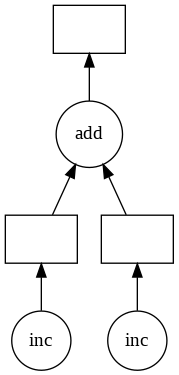

In [ ]:
z.visualize()

To get the result, call `compute`. Notice that this runs faster than the original code.

In [ ]:
%%time

z.compute()

CPU times: user 20.2 ms, sys: 1.98 ms, total: 22.2 ms
Wall time: 2.04 s


5

### Parallelizing a `for` loop


In [ ]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
%%time

results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

CPU times: user 49.9 ms, sys: 6.86 ms, total: 56.8 ms
Wall time: 8.01 s


In [ ]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)

total.compute()

CPU times: user 30.3 ms, sys: 4.42 ms, total: 34.7 ms
Wall time: 4.01 s


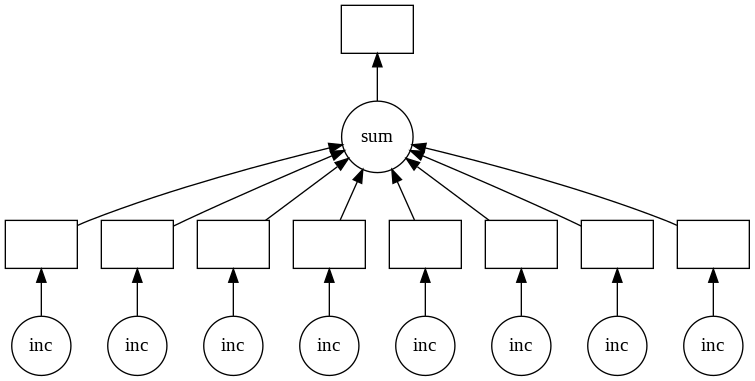

In [ ]:
total.visualize()

# Dask DataFrame

Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM. `dask.dataframe` will scale to datasets much larger than memory. <br>
<br>
The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame`. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.
<br>
<br>
Lets try this with an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area.

In [ ]:
# download the NYC Flights dataset to our workspace
import urllib.request

print("- Downloading NYC Flights dataset... ", end='', flush=True)
url = "https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz"
filename, headers = urllib.request.urlretrieve(url, 'nycflights.tar.gz')
print("Done!", flush=True)

- Downloading NYC Flights dataset... Done!


In [ ]:
import tarfile

# extract the .csv files from the tar file
with tarfile.open(filename, mode='r:gz') as flights:
            flights.extractall('data/')

In [ ]:
import os
import dask.dataframe as dd

df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Notice that the respresentation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

In [ ]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,81,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,81,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,81,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,81,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,81,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [ ]:
df.tail()

ValueError: ignored

In [ ]:
# for coloumns with mixed dtypes we have to infer the correct type i.e specify datatypes manually
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [ ]:
df.tail()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,256.0,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,256.0,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,256.0,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,256.0,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,256.0,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


## Computations with `dask.dataframe`

We want to compute the maximum of the `DepDelay` column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums. Quite cumbersome. <br>
<br>
`dask.dataframe` lets us write pandas-like code, that operates on larger than memory datasets in parallel:

In [ ]:
%time df.DepDelay.max().compute()

CPU times: user 8.86 s, sys: 459 ms, total: 9.32 s
Wall time: 5.84 s


1435.0

As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method:

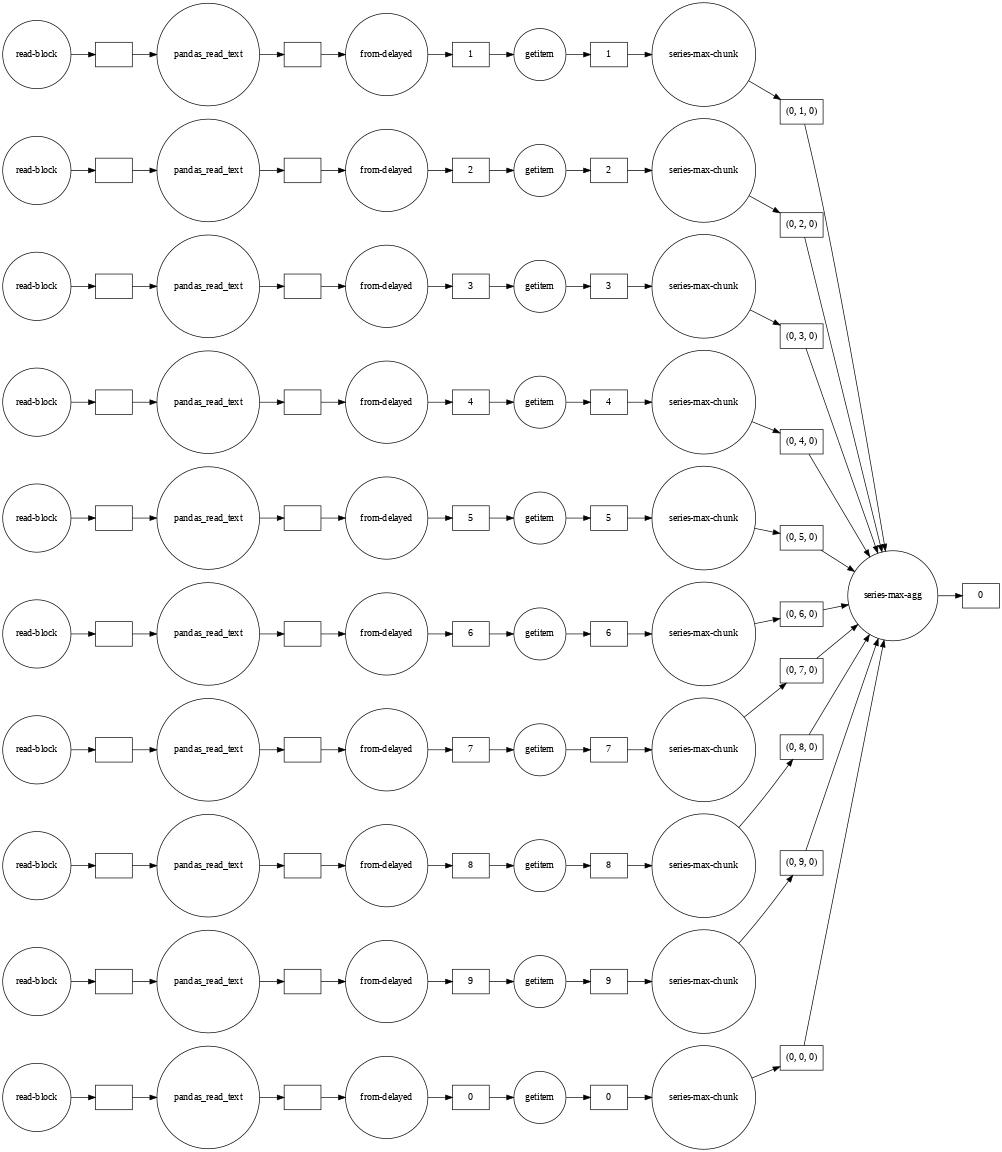

In [ ]:
df.DepDelay.max().visualize(rankdir="LR", size="12, 12!")

# Machine Learning with Dask

In [ ]:
# You can grab columns from the Dask DataFrame just as you would with Pandas
df_train = df[['CRSDepTime',  'CRSArrTime', 'Cancelled']]

In [ ]:
# you can query the shape (note delayed # of samples)
df_train.shape

(Delayed('int-f5d39a64-fb12-42fc-8401-ae7a9f518a22'), 3)

In [ ]:
# perform searches and operations on the data
df_train.isnull().sum().compute()

CRSDepTime    0
CRSArrTime    0
Cancelled     0
dtype: int64

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

# Build a simple Keras Model
model = Sequential()
model.add(Dense(20, input_dim=df_train.shape[1], activation='relu'))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='sgd',)

In [ ]:
# generate batches of data from our dask dataframe
def dask_data_generator(df, fraction=0.01):
  while True:
    batch = df.sample(frac=fraction)
    X = batch.iloc[:, :-1]
    y = batch.iloc[:, -1]
    yield (X.compute(), y.compute())

In [ ]:
batch = df_train.sample(frac=0.001)
X = batch.iloc[:, :-1]
print(type(X.values))
y = batch.iloc[:, -1]
print(type(X.compute().to_numpy()))
print(X.compute().to_numpy().shape)

<class 'dask.dataframe.core.DataFrame'>
<class 'numpy.ndarray'>
(2613, 2)


In [ ]:
# never run out-of-memory while training
model.fit_generator(generator=dask_data_generator(df_train),
                    steps_per_epoch=100)

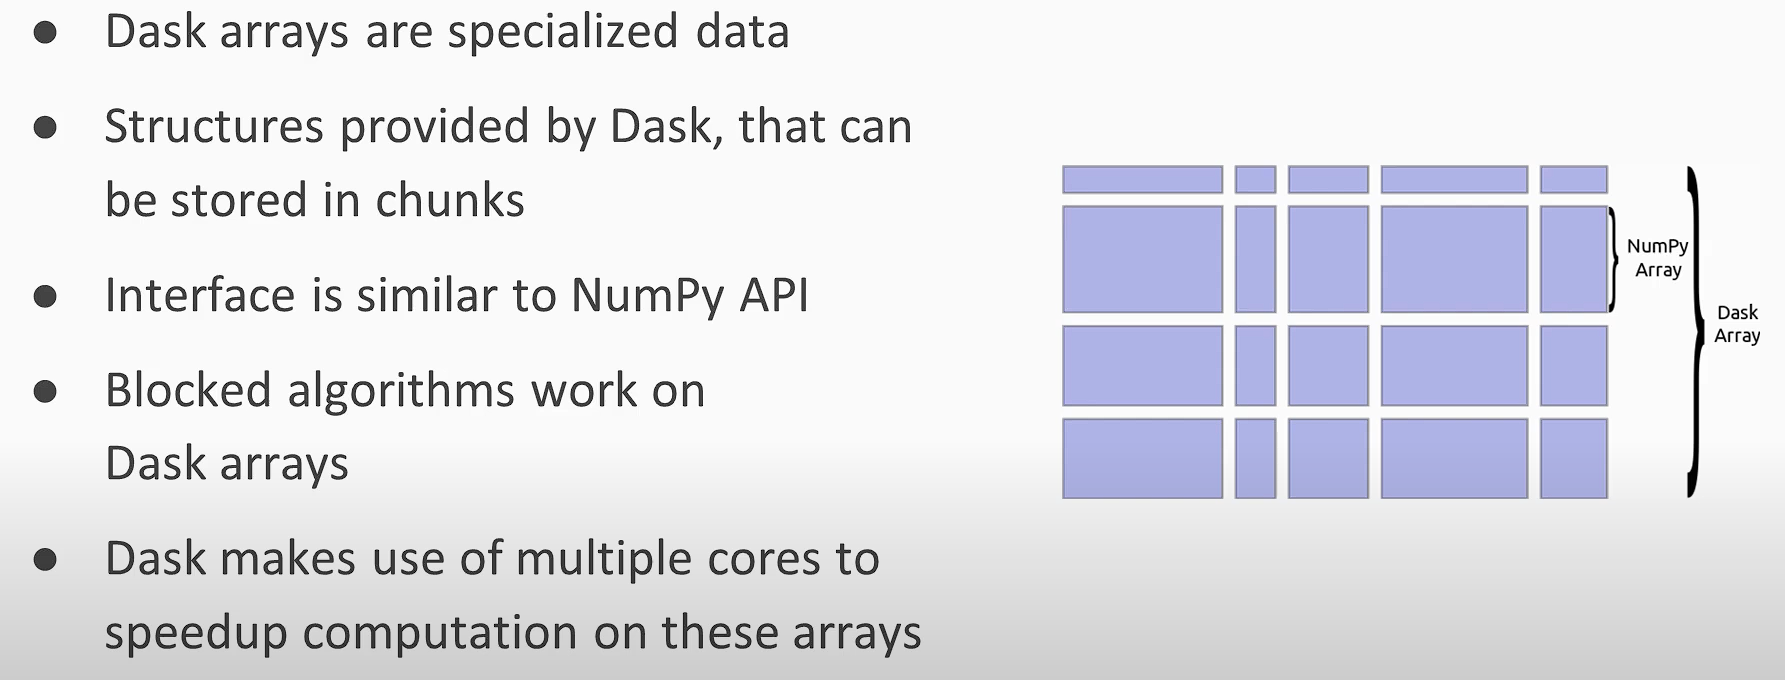

In [3]:
from IPython.display import Image
Image("dask1.PNG")

In [4]:
!git clone https://github.com/jacobtomlinson/dask-video-tutorial.git

Cloning into 'dask-video-tutorial'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 184 (delta 22), reused 28 (delta 11), pack-reused 142
Receiving objects: 100% (184/184), 34.07 MiB | 17.45 MiB/s, done.
Resolving deltas: 100% (101/101), done.


In [7]:
!pip install fsspec

     |████████████████████████████████| 133 kB 3.3 MB/s 


In [9]:
import dask.dataframe

ddf = dask.dataframe.read_csv('/content/dask-video-tutorial/data/beer_small.csv', blocksize=12e6)# 12 MB chunks

In [10]:
ddf

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
npartitions=2,,,,,,,,,,,,,,
,int64,int64,object,int64,float64,float64,float64,object,object,float64,float64,object,float64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...


### What is this Dask Dataframe?

A large, virtual dataframe divided along the index into multiple Pandas dataframes:

<img src="/content/dask-video-tutorial/images/dask-dataframe.svg" width="400px">

In [11]:
ddf.map_partitions(type).compute()

0    <class 'pandas.core.frame.DataFrame'>
1    <class 'pandas.core.frame.DataFrame'>
dtype: object

In [12]:
ddf.head()

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,784200,952,Great Dane Pub & Brewing Company (Downtown),1136269921,4.5,4.0,4.0,dirtylou,American IPA,4.0,4.0,Texas Speedbump IPA,NaN,11846
1,1305265,29,Anheuser-Busch,1234830966,4.5,4.0,3.0,talkinghatrack,Light Lager,3.0,4.0,Bud Light Lime,4.2,41821
2,1526298,45,Brooklyn Brewery,1078599557,4.5,4.0,4.0,PopeJonPaul,Scotch Ale / Wee Heavy,4.0,4.5,Brooklyn Heavy Scotch Ale,7.5,16355
3,450647,590,New Glarus Brewing Company,1288790879,4.5,4.5,4.5,sweemzander,American Wild Ale,4.5,4.0,R&D Bourbon Barrel Kriek,5.5,60588
4,1223094,4,Allagash Brewing Company,1295320417,4.5,4.5,4.0,Jmoore50,American Wild Ale,4.0,4.0,Allagash Victor Francenstein,9.7,56665


In [14]:
ddf[ddf.beer_style.str.contains('IPA')].head()

,Unnamed: 0,brewery_id,brewery_name,review_time,review_overall,review_aroma,review_appearance,review_profilename,beer_style,review_palate,review_taste,beer_name,beer_abv,beer_beerid
0,784200,952,Great Dane Pub & Brewing Company (Downtown),1136269921,4.5,4.0,4.0,dirtylou,American IPA,4.0,4.0,Texas Speedbump IPA,NaN,11846
9,426580,666,Emerson's Brewery,1192461083,5.0,4.0,4.5,Lukie,English India Pale Ale (IPA),4.0,5.0,1812 India Pale Ale,4.7,4594
24,728901,17963,Nectar Ales,1312873910,3.5,4.0,3.5,Sensaray,American IPA,3.5,3.5,IPA Nectar,6.8,9024
26,745463,12877,NINE G Brewing Company,1189556274,4.0,4.5,4.0,Phatz,American Double / Imperial IPA,4.0,4.5,Infidel Imperial IPA,8.4,31041
28,94239,140,Sierra Nevada Brewing Co.,1269655771,4.0,4.5,4.5,CaptainIPA,American IPA,4.5,4.5,Sierra Nevada Torpedo Extra IPA,7.2,30420


In [15]:
ipa = ddf[ddf.beer_style.str.contains('IPA')]

In [16]:
mean_ipa_review = ipa.groupby('brewery_name').review_overall.agg(['mean','count'])

In [17]:
mean_ipa_review.compute()

,mean,count
brewery_name,,
(512) Brewing Company,3.785714,7
1516 Brewing Company,4.000000,1
1702 / The Address Brewing Co.,4.000000,1
21st Amendment Brewery,3.923469,98
7 Seas Brewery and Taproom,4.000000,1
...,...,...
Yak and Yeti,4.500000,1
York Brewery Company Limited,4.000000,1
Yukon Brewing Company,4.250000,2


In [18]:
mean_ipa_review.nlargest(20, 'mean').compute()

,mean,count
brewery_name,,
Burnside Brewing Co.,5.000000,1
Elk Mountain Brewing,5.000000,1
Pioneer Brewing Co.,5.000000,2
Crouch Vale Brewery Limited,5.000000,1
Feral Brewing Co.,5.000000,1
Flour City Brewing Co.,5.000000,1
La Jolla Brew House,5.000000,1
Uncle Buck's Brewery & Steakhouse,5.000000,1
Glacier Brewhouse,4.875000,4


There are writing counterparts to read methods which we can use:

- `read_csv` \ `to_csv`
- `read_hdf` \ `to_hdf`
- `read_json` \ `to_json`
- `read_parquet` \ `to_parquet`

In [19]:
mean_ipa_review.to_csv('ipa-*.csv') #the * is where the partition number will go

['/content/ipa-0.csv']

In [20]:
import dask.dataframe

ddf = dask.dataframe.read_csv('/content/dask-video-tutorial/data/pageviews_small.csv', sep=' ', blocksize=10e6)

ddf.columns = ['project', 'page', 'requests', 'x']

ddf2 = ddf.drop('x', axis=1)

ddf3 = ddf2[ddf2.project == 'en']
ddf3

,project,page,requests
npartitions=4,,,
,object,object,int64
,...,...,...
,...,...,...
,...,...,...
,...,...,...


In [21]:
ddf2.count().compute() #all

project     1118999
page        1118988
requests    1118999
dtype: int64

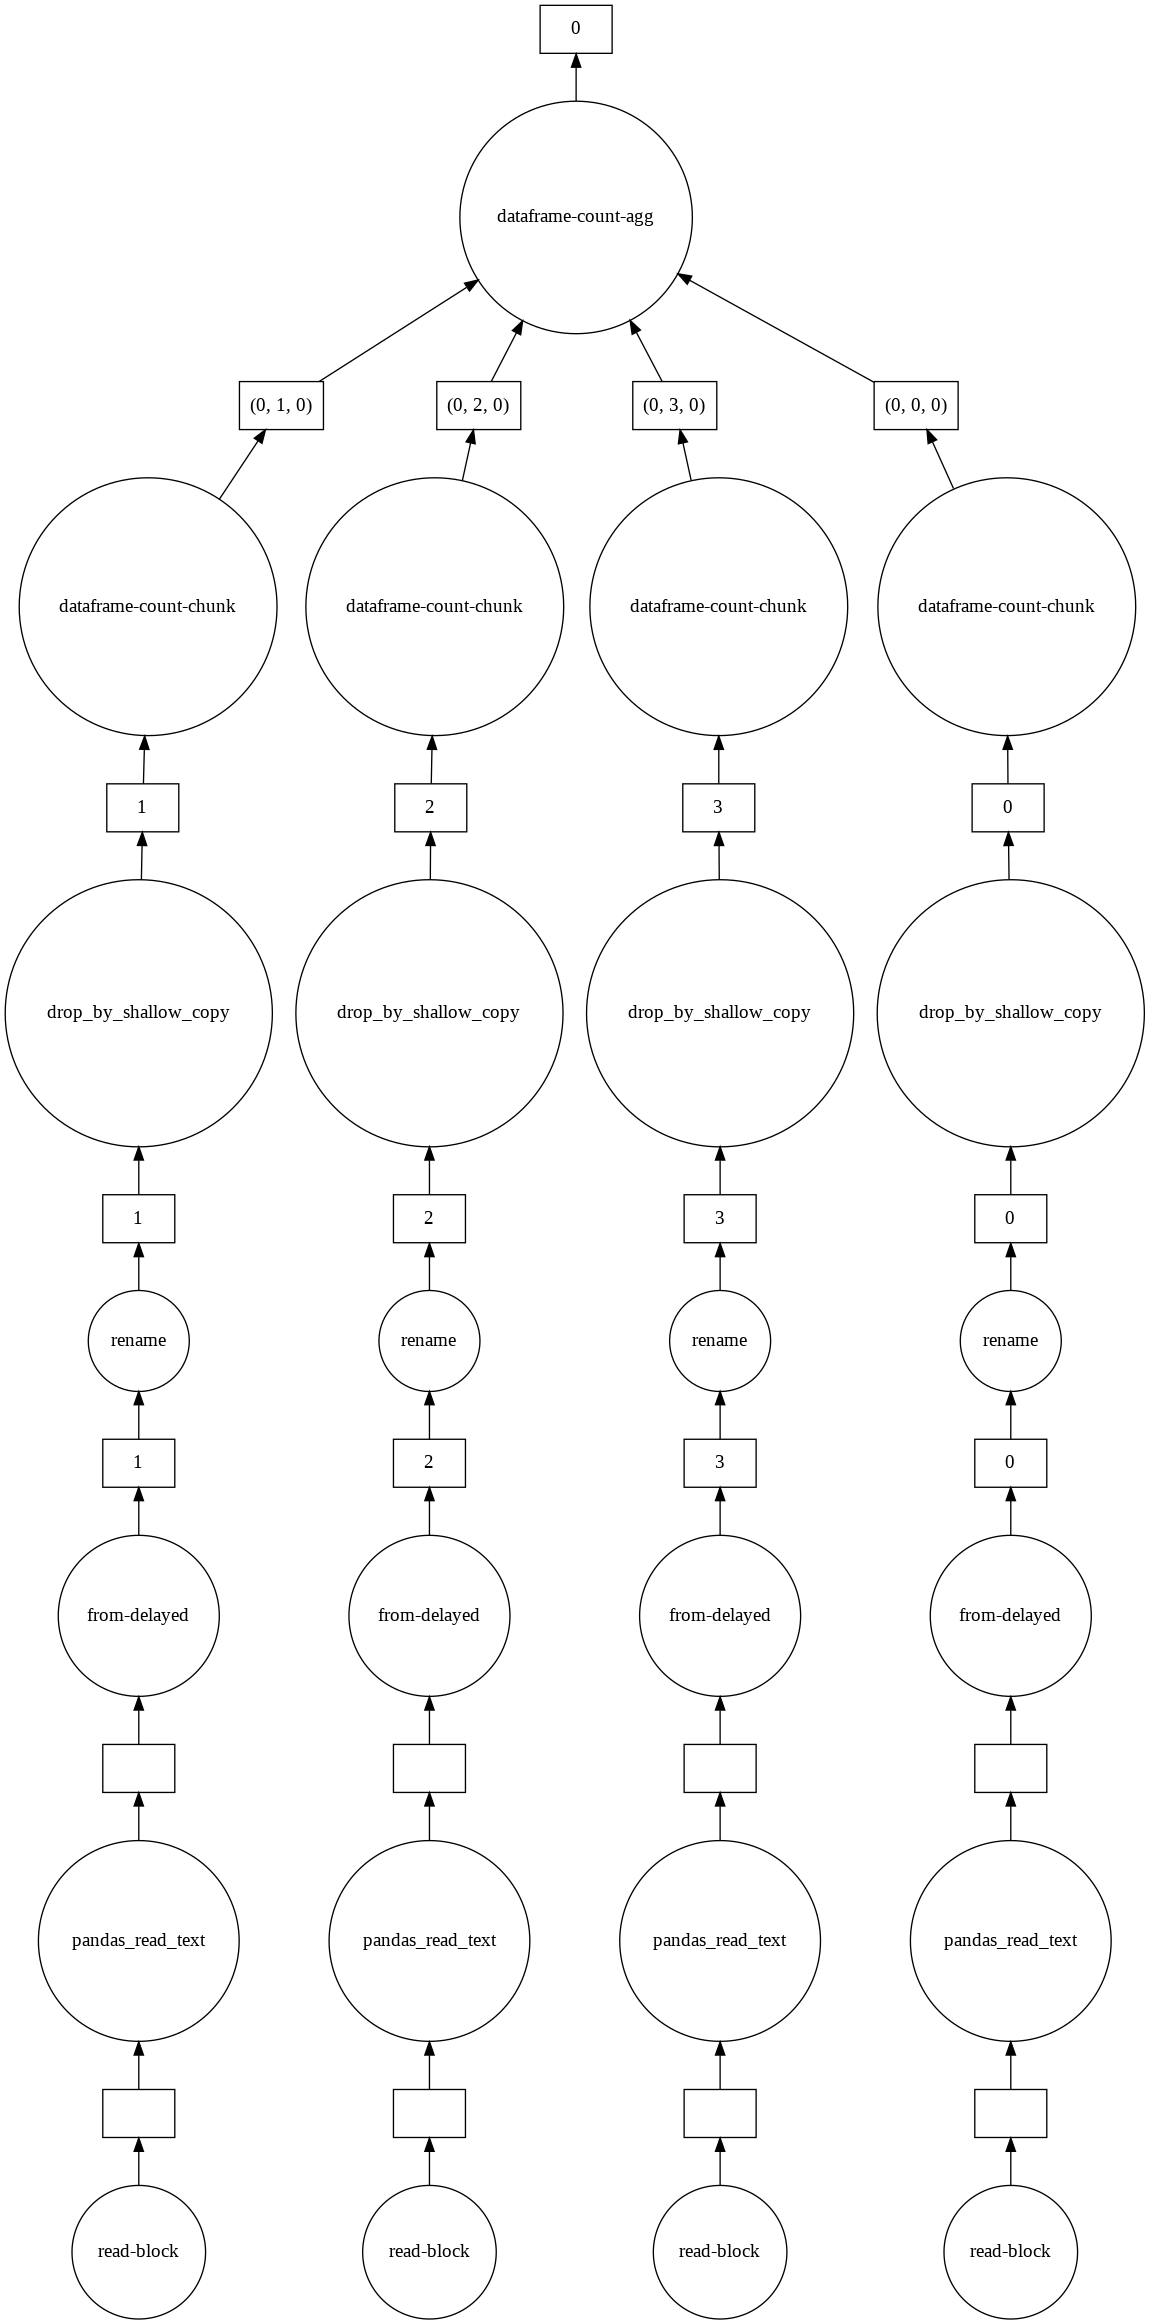

In [22]:
ddf2.count().visualize()

# Dask Array

Depending on the focus of your work, Dask Array is likely to be the first interface you use for Dask after Dataframe ... or perhaps just the first interface you use (e.g., if you work primarily with NumPy).

Dask Array implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using all of our cores. We coordinate these blocked algorithms using Dask graphs.

Dask arrays coordinate many NumPy arrays arranged into a grid. These NumPy arrays may live on disk or on other machines.

## Dask Arrays

- Dask arrays are chunked, n-dimensional arrays
- Can think of a Dask array as a collection of NumPy `ndarray` arrays
- Dask arrays implement a large subset of the NumPy API using blocked algorithms
- For many purposes Dask arrays can serve as drop-in replacements for NumPy arrays

In [24]:
import numpy as np
import dask.array as da

In [25]:
a_np = np.arange(1, 50, 3)
a_np

array([ 1,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49])

In [26]:
a_da = da.arange(1, 50, 3, chunks=5)
a_da

dask.array<arange, shape=(17,), dtype=int64, chunksize=(5,), chunktype=numpy.ndarray>

In [34]:
print(a_da.dtype)
print(a_da.shape)
print(type(a_da))

int64
(17,)
<class 'dask.array.core.Array'>


In [29]:
print(a_np.dtype)
print(a_np.shape)

int64
(17,)


In [28]:
print(a_da.chunks)
print(a_da.chunksize)

((5, 5, 5, 2),)
(5,)


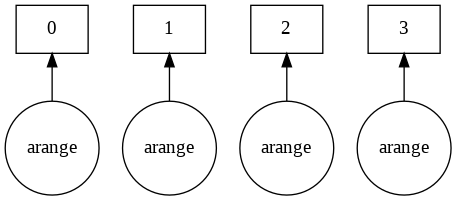

In [30]:
a_da.visualize()

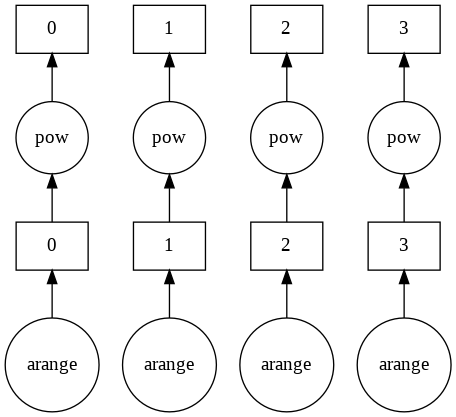

In [31]:
(a_da ** 2).visualize()

In [32]:
(a_da ** 2).compute()

array([   1,   16,   49,  100,  169,  256,  361,  484,  625,  784,  961,
       1156, 1369, 1600, 1849, 2116, 2401])

In [33]:
type((a_da ** 2).compute())

numpy.ndarray

Dask arrays support a large portion of the NumPy interface:

- Arithmetic and scalar mathematics: `+`, `*`, `exp`, `log`, ...

- Reductions along axes: `sum()`, `mean()`, `std()`, `sum(axis=0)`, ...

- Tensor contractions / dot products / matrix multiply: `tensordot`

- Axis reordering / transpose: `transpose`

- Slicing: `x[:100, 500:100:-2]`

- Fancy indexing along single axes with lists or numpy arrays: `x[:, [10, 1, 5]]`

- Array protocols like `__array__` and `__array_ufunc__`

- Some linear algebra: `svd`, `qr`, `solve`, `solve_triangular`, `lstsq`, ...

- ...

See the [Dask array API docs](http://docs.dask.org/en/latest/array-api.html) for full details about what portion of the NumPy API is implemented for Dask arrays.

### Blocked Algorithms

Dask arrays are implemented using _blocked algorithms_. These algorithms break up a computation on a large array into many computations on smaller peices of the array. This minimizes the memory load (amount of RAM) of computations and allows for working with larger-than-memory datasets in parallel.

In [35]:
x = da.random.random(20, chunks=5)
x

dask.array<random_sample, shape=(20,), dtype=float64, chunksize=(5,), chunktype=numpy.ndarray>

In [36]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

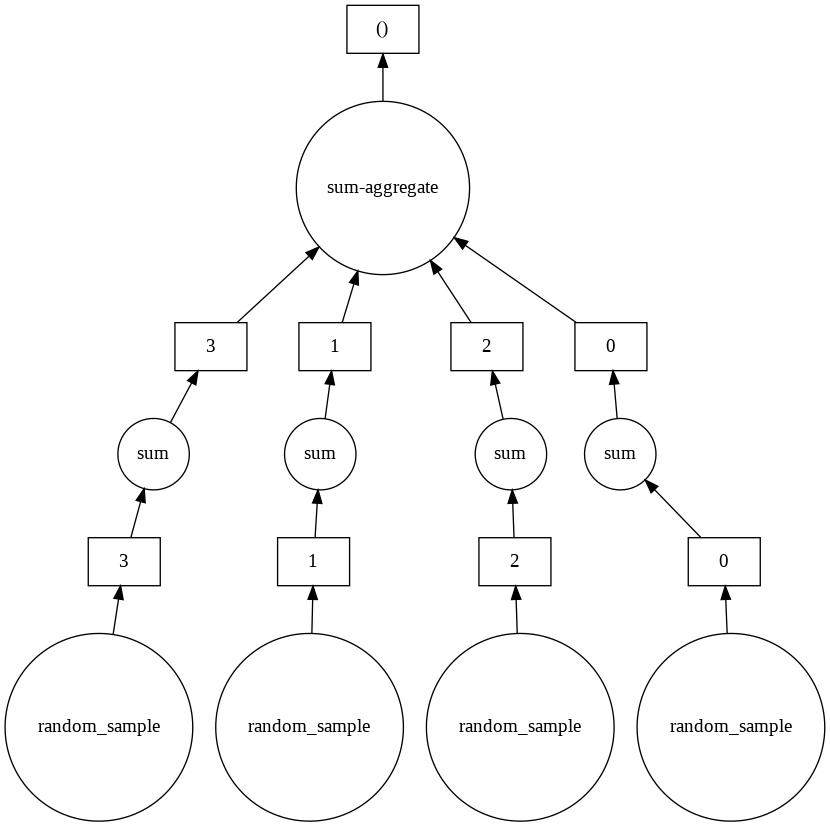

In [37]:
result.visualize() #below you see 4 chunks

In [38]:
result.compute()

9.70453340859925

Dask supports a large portion of the NumPy API. This can be used to build up more complex computations using the familiar NumPy operations you're used to.

In [39]:
x = da.random.random(size=(15, 15), chunks=(10, 5))
x

dask.array<random_sample, shape=(15, 15), dtype=float64, chunksize=(10, 5), chunktype=numpy.ndarray>

In [40]:
result = (x + x.T).sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

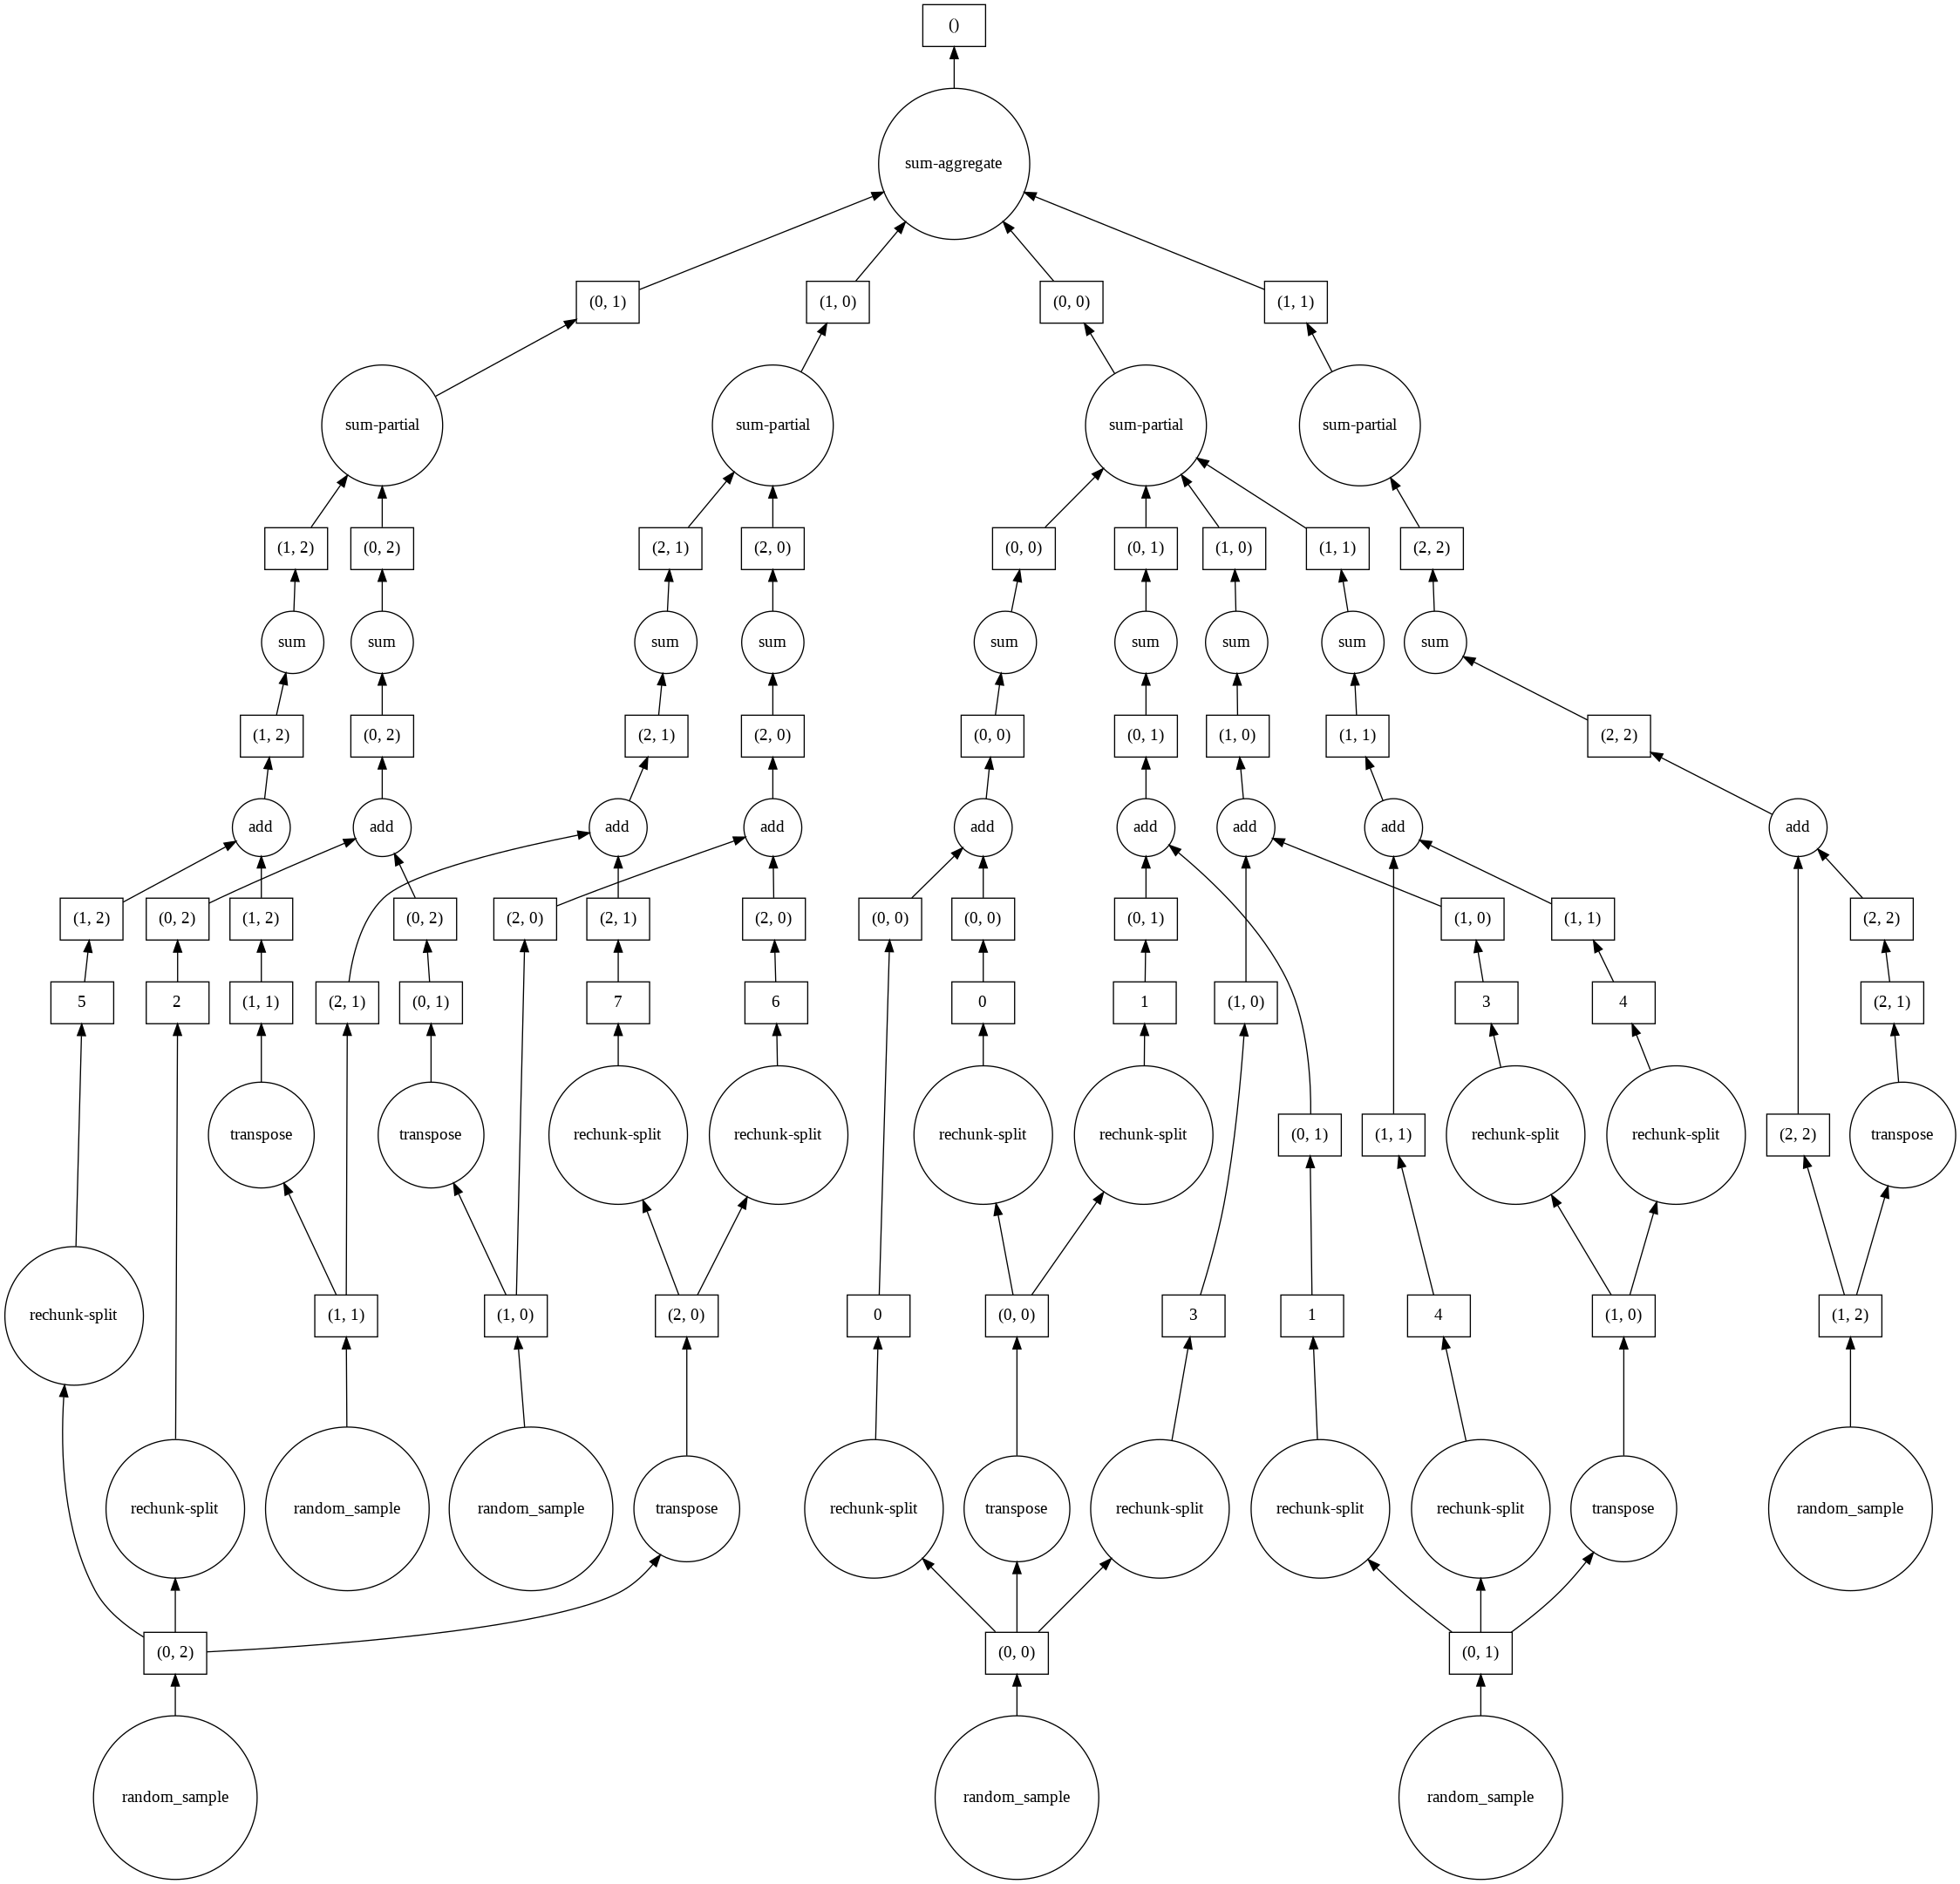

In [41]:
result.visualize()

In [42]:
result.compute()

215.39939236758968

We can perform computations on larger-than-memory arrays!

In [43]:
x = da.random.random(size=(20_000, 20_000), chunks=(2_000, 2_000))
x

dask.array<random_sample, shape=(20000, 20000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

In [44]:
result = (x + x.T).sum()
result

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [45]:
result.compute()

400019336.2447352

Dask-ML
====================================================================

__(initial notes are courtesy of the Dask project homepage at ml.dask.org)__

Dask-ML provides scalable machine learning in Python using [Dask](https://dask.org/) alongside popular machine learning libraries like [Scikit-Learn](http://scikit-learn.org/).

The idea is to support Pandas + Scikit style ML for parallel scenarios, with code patterns you're used to:

```python
import dask.dataframe as dd
df = dd.read_parquet('...')
data = df[['age', 'income', 'married']]
labels = df['outcome']

from dask_ml.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(data, labels)
```

How does this work?
-------------------------------------------------------------------------------------------

Modern machine learning algorithms employ a wide variety of techniques. Scaling these requires a similarly wide variety of different approaches. Generally solutions fall into the following three categories:

### Parallelize Scikit-Learn Directly

Scikit-Learn already provides parallel computing on a single machine with [Joblib](http://joblib.readthedocs.io/en/latest/). Dask extends this parallelism to many machines in a cluster. This works well for modest data sizes but large computations, such as random forests, hyper-parameter optimization, and more.

```python
from dask.distributed import Client
import joblib

client = Client()  # Connect to a Dask Cluster

with joblib.parallel_backend('dask'):
    # Your normal scikit-learn code here
```

See [Dask-ML Joblib documentation](https://ml.dask.org/joblib.html) for more information.

*Note that this is an active collaboration with the Scikit-Learn development team. This functionality is progressing quickly but is in a state of rapid change.*

### Reimplement Scalable Algorithms with Dask Array

Some machine learning algorithms are easy to write down as Numpy algorithms. In these cases we can replace Numpy arrays with Dask arrays to achieve scalable algorithms easily. This is employed for [linear models](https://ml.dask.org/glm.html), [pre-processing](https://ml.dask.org/preprocessing.html), and [clustering](https://ml.dask.org/clustering.html).

```python
from dask_ml.preprocessing import Categorizer, DummyEncoder
from dask_ml.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(data, labels)
```

### Partner with other distributed libraries

Other machine learning libraries like XGBoost and TensorFlow already have distributed solutions that work quite well. Dask-ML makes no attempt to re-implement these systems. Instead, Dask-ML makes it easy to use normal Dask workflows to prepare and set up data, then it deploys XGBoost or Tensorflow *alongside* Dask, and hands the data over.

```python
from dask_ml.xgboost import XGBRegressor

est = XGBRegressor(...)
est.fit(train, train_labels)
```

See [Dask-ML + XGBoost](https://ml.dask.org/xgboost.html) or [Dask-ML + TensorFlow](https://ml.dask.org/tensorflow.html) documentation for more information.

Scikit-Learn API[](https://ml.dask.org/#scikit-learn-api "Permalink to this headline")
--------------------------------------------------------------------------------------

In all cases Dask-ML endeavors to provide a single unified interface around the familiar NumPy, Pandas, and Scikit-Learn APIs. Users familiar with Scikit-Learn should feel at home with Dask-ML.

* * *

# Let's try it:

In [2]:
import dask.dataframe

ddf = dask.dataframe.read_csv('/content/dask-video-tutorial/data/diamonds.csv', blocksize=1e6, assume_missing=True)
ddf

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
npartitions=4,,,,,,,,,,,
,float64,float64,object,object,object,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...


In [15]:
ddf = ddf.drop(['Unnamed: 0'], axis=1)
ddf

,carat,cut,color,clarity,depth,table,price,x,y,z
npartitions=4,,,,,,,,,,
,float64,category[known],category[known],category[known],float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [16]:
ddf = ddf.categorize()
ddf

,carat,cut,color,clarity,depth,table,price,x,y,z
npartitions=4,,,,,,,,,,
,float64,category[known],category[known],category[known],float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...


In [17]:
prepared = dask.dataframe.reshape.get_dummies(ddf)
prepared

,carat,depth,table,price,x,y,z,cut_Ideal,cut_Premium,cut_Good,cut_Very Good,cut_Fair,color_E,color_I,color_J,color_H,color_F,color_G,color_D,clarity_SI2,clarity_SI1,clarity_VS1,clarity_VS2,clarity_VVS2,clarity_VVS1,clarity_I1,clarity_IF
npartitions=4,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8,uint8
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Alternatively, we could use scikit-learn style preprocessing steps, though the relevant APIs are still evolving a bit:

```python
from sklearn.pipeline import make_pipeline
from dask_ml.preprocessing import Categorizer, DummyEncoder
from dask_ml.linear_model import LinearRegression

pipe = make_pipeline(
    Categorizer(),
    DummyEncoder()
)

pipe.fit(ddf)

prepared = pipe.transform(ddf)
```

In [18]:
prepared.head()

,carat,depth,table,price,x,y,z,cut_Ideal,cut_Premium,cut_Good,cut_Very Good,cut_Fair,color_E,color_I,color_J,color_H,color_F,color_G,color_D,clarity_SI2,clarity_SI1,clarity_VS1,clarity_VS2,clarity_VVS2,clarity_VVS1,clarity_I1,clarity_IF
0,0.23,61.5,55.0,326.0,3.95,3.98,2.43,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.21,59.8,61.0,326.0,3.89,3.84,2.31,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.23,56.9,65.0,327.0,4.05,4.07,2.31,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0.29,62.4,58.0,334.0,4.20,4.23,2.63,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0.31,63.3,58.0,335.0,4.34,4.35,2.75,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0


In [19]:
y = prepared.price.to_dask_array(lengths=True)
y

dask.array<values, shape=(53940,), dtype=float64, chunksize=(17041,), chunktype=numpy.ndarray>

In [20]:
arr = prepared.drop('price', axis=1).to_dask_array(lengths=True)
arr

dask.array<values, shape=(53940, 26), dtype=float64, chunksize=(17041, 26), chunktype=numpy.ndarray>

In [54]:
!pip install dask_ml

     |████████████████████████████████| 148 kB 6.0 MB/s 
     |████████████████████████████████| 15.7 MB 268 kB/s 
     |████████████████████████████████| 822 kB 55.3 MB/s 
     |████████████████████████████████| 802 kB 66.0 MB/s 
     |████████████████████████████████| 802 kB 56.8 MB/s 
     |████████████████████████████████| 793 kB 44.9 MB/s 
     |████████████████████████████████| 793 kB 51.8 MB/s 
     |████████████████████████████████| 791 kB 52.6 MB/s 
     |████████████████████████████████| 786 kB 55.0 MB/s 
     |████████████████████████████████| 779 kB 52.2 MB/s 
     |████████████████████████████████| 778 kB 42.3 MB/s 
     |████████████████████████████████| 776 kB 45.7 MB/s 
     |████████████████████████████████| 769 kB 49.8 MB/s 
     |████████████████████████████████| 766 kB 50.5 MB/s 
     |████████████████████████████████| 1.0 MB 45.9 MB/s 
     |████████████████████████████████| 722 kB 59.5 MB/s 
     |████████████████████████████████| 722 kB 50.9 MB/s 
     |█████████

In [21]:
from dask_ml.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(arr, y, test_size=0.1)

X_train

dask.array<concatenate, shape=(48544, 26), dtype=float64, chunksize=(15336, 26), chunktype=numpy.ndarray>

In [22]:
y_train

dask.array<concatenate, shape=(48544,), dtype=float64, chunksize=(15336,), chunktype=numpy.ndarray>

In [23]:
from dask_ml.linear_model import LinearRegression

lr = LinearRegression(solver='lbfgs', max_iter=10)
lr_model = lr.fit(X_train, y_train)

In [24]:
lr_model.coef_

array([ 1.15010645e+01,  1.02570259e+04,  1.07994848e+01, -3.17999398e+01,
        3.77562052e+02, -4.47644604e+02, -7.74536628e+02,  1.24359518e+02,
        2.42978769e+01, -1.56668528e+02,  6.19501473e+00, -7.75740357e+02,
        4.61133995e+02, -8.66006209e+02, -1.78624486e+03, -3.61172120e+02,
        3.46057713e+02,  1.06666014e+02,  7.00192717e+02, -1.40661671e+03,
       -4.10734056e+02,  6.23548497e+02,  2.49952999e+02,  1.02616588e+03,
        1.16154444e+03, -4.26566075e+03])

In [25]:
y_predicted = lr_model.predict(X_test)

y_predicted

dask.array<sum-aggregate, shape=(5396,), dtype=float64, chunksize=(1705,), chunktype=numpy.ndarray>

In [26]:
y_test

dask.array<concatenate, shape=(5396,), dtype=float64, chunksize=(1705,), chunktype=numpy.ndarray>

In [27]:
from dask_ml.metrics import mean_squared_error
from math import sqrt

sqrt(mean_squared_error(y_test, y_predicted))

1139.2216488689942

## Dask Bag

Dask's __Bag__ interface is the last of the high-level interfaces for manipulating data with Dask.

A __Bag__ is an unordered collection that *can* contain the same item multiple times (unlike a Python Set, which cannot distinguish duplicates). A __Bag__ is a little bit like a Python Counter. 

But its main feature is that it can be partitioned and processed in parallel.

Bags are documented at https://docs.dask.org/en/latest/bag.html

In [28]:
import dask.bag as db

b = db.from_sequence(range(30), npartitions=4) # generates a list of 30 elements

In [29]:
b

dask.bag<from_sequence, npartitions=4>

In [30]:
b.count().compute()

30

In [31]:
b.npartitions

4

We program bags using functional-programming abstractions:

In [32]:
b_squared = b.map(lambda x:x**2)

In [33]:
b_squared.take(5) #just like head in dataframe

(0, 1, 4, 9, 16)

In [34]:
even_odd_groups = b_squared.groupby(lambda x: x%2)

In [35]:
even_odd_groups.compute()

[(0, [0, 4, 16, 36, 64, 100, 144, 196, 256, 324, 400, 484, 576, 676, 784]),
 (1, [1, 9, 25, 49, 81, 121, 169, 225, 289, 361, 441, 529, 625, 729, 841])]

In [36]:
even_odd_groups.take(1)[0][1]

[64, 100, 144, 196, 0, 4, 16, 36, 256, 324, 400, 484, 576, 676, 784]

Remember, bags aren't ordered -- so you may or may not see the output in ascending sequence. 

Also, as with many data-parallel collection frameworks, we need need to be careful about "materializing groups" or "touching the data" ... In this case, we've asked Dask to fully compute the two groups (odd and even squares). 

It's a silly example, but we definitely want to be careful about this, since on real large datasets, it's common for individual groups to be too large to fit in memory (imagine taking your company's transactions and grouping by country!)

Whenever you think "group-by" (and maybe if you're thinking group-by you should think about dataframe instead) it's good to think, "... and then what?" ...

Typically, group-by goes with an aggregation like "group-by and count" or "group-by and add" -- in those cases, use the alternative operation `foldby`

In [37]:
def add(a,b):
    return a+b

b_squared.foldby(lambda n:n%2, add, 0, add, 0).compute()

[(0, 4060), (1, 4495)]

In [38]:
def count(total, item):
    return total+1

b_squared.foldby(lambda n:n%2, count, 0, add, 0).compute()

[(0, 15), (1, 15)]

## `concurrent.futures` interface

The Dask distributed scheduler implements a superset of Python's [`concurrent.futures`](https://docs.python.org/3/library/concurrent.futures.html) interface that allows for finer control and asynchronous computation.

The `submit` function sends a function and arguments to the distributed scheduler for processing. They return `Future` objects that refer to remote data on the cluster. The `Future` returns immediately while the computations run remotely in the background. There is no blocking of the local Python session.

In [54]:
import random
import time

def inc(x):
    time.sleep(random.uniform(0, 2))
    return x + 1

In [55]:
from dask.distributed import Client

client = Client()  # start local workers as processes
# or
#client = Client(processes=False)  # start local workers as threads

/usr/local/lib/python3.7/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37425 instead
  http_address["port"], self.http_server.port


In [56]:
f = client.submit(inc, 7.2)  # Submits inc(7.2) to the distributed scheduler
print(f)
print(type(f))

<Future: pending, key: inc-9da825771ba63bfac4e7c48df67457f0>
<class 'distributed.client.Future'>


In [57]:
f.result()

8.2

In [58]:
print(f)# see status changes to finished

<Future: finished, type: builtins.float, key: inc-9da825771ba63bfac4e7c48df67457f0>


In [59]:
del f #to delete futures

In [60]:
data = range(10)
futures = client.map(inc, data)
futures

[<Future: pending, key: inc-2b0ebec86d660080f35c3fd3529e2d9a>,
 <Future: pending, key: inc-e6cbbd66ad80e923484af7e80e143571>,
 <Future: pending, key: inc-f7fe1f3576a21069e4b1e0c07f5b04da>,
 <Future: pending, key: inc-55e79c91a1ae7c7a71070eddfcb7e04e>,
 <Future: pending, key: inc-49e96921a30701699e3c31965a09d99b>,
 <Future: pending, key: inc-127b2e8540fe56a36e9f3cbfc06a5eb1>,
 <Future: pending, key: inc-908c6e23fc9e81ddaf1ea072d088451f>,
 <Future: pending, key: inc-1c1bad584bf4e9a4c217af9e99bac28f>,
 <Future: pending, key: inc-0d363fc557134daa721027db4d538531>,
 <Future: pending, key: inc-60dacb8d81977774bb3863c2748a5afe>]

In [61]:
results = client.gather(futures)
# Same as results = [future.result() for future in futures]
results

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [62]:
data = range(10)
futures = client.map(inc, data)
futures

[<Future: finished, type: builtins.int, key: inc-2b0ebec86d660080f35c3fd3529e2d9a>,
 <Future: finished, type: builtins.int, key: inc-e6cbbd66ad80e923484af7e80e143571>,
 <Future: finished, type: builtins.int, key: inc-f7fe1f3576a21069e4b1e0c07f5b04da>,
 <Future: finished, type: builtins.int, key: inc-55e79c91a1ae7c7a71070eddfcb7e04e>,
 <Future: finished, type: builtins.int, key: inc-49e96921a30701699e3c31965a09d99b>,
 <Future: finished, type: builtins.int, key: inc-127b2e8540fe56a36e9f3cbfc06a5eb1>,
 <Future: finished, type: builtins.int, key: inc-908c6e23fc9e81ddaf1ea072d088451f>,
 <Future: finished, type: builtins.int, key: inc-1c1bad584bf4e9a4c217af9e99bac28f>,
 <Future: finished, type: builtins.int, key: inc-0d363fc557134daa721027db4d538531>,
 <Future: finished, type: builtins.int, key: inc-60dacb8d81977774bb3863c2748a5afe>]

The results are ready right away ... and ... the keys are the same. That's because all of the same objects are involved, and the results are still in the cluster memory.

The `concurrent.futures` API even allows you to submit tasks based on the output of other tasks. This gives more flexibility in situations where the computations may evolve over time.

```python
from dask.distributed import as_completed

seq = as_completed(futures)

for future in seq:
    y = future.result()
    if condition(y):
        new_future = client.submit(...)
        seq.add(new_future)  # add back into the loop
```

In [63]:
client.close()

# Distributed

As we covered at the beginning Dask has the ability to run work on mulitple machines using the distributed scheduler.

Until now we have actually been using the distributed scheduler for our work, but just on a single machine.

When we instantiate a `Client()` object with no arguments it will attempt to locate a Dask cluster. It will check your local Dask config and environment variables to see if connection information has been specified. If not it will create an instance of `LocalCluster` and use that.

*Specifying connection information in config is useful for system administrators to provide access to their users. We do this in the [Dask Helm Chart for Kubernetes](https://github.com/dask/helm-chart/blob/master/dask/templates/dask-jupyter-deployment.yaml#L46-L48), the chart installs a multi-node Dask cluster and a Jupyter server on a Kubernetes cluster and Jupyter is preconfigured to discover the distributed cluster.*

## Local Cluster

Let's explore the `LocalCluster` object ourselves and see what it is doing.

In [64]:
from dask.distributed import LocalCluster, Client

In [65]:
cluster = LocalCluster()
cluster

/usr/local/lib/python3.7/dist-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37013 instead
  http_address["port"], self.http_server.port


Creating a cluster object will create a Dask scheduler and a number of Dask workers. If no arguments are specified then it will autodetect the number of CPU cores your system has and the amount of memory and create workers to appropriately fill that.

You can also specify these arguments yourself. Let's have a look at the docstring to see the options we have available.

*These arguments can also be passed to `Client` and in the case where it creates a `LocalCluster` they will just be passed on down the line.*

In [52]:
LocalCluster?

In [66]:
cluster.get_logs()#get the log output from the scheduler and all the workers with the get_logs() method.

{'Cluster': '',
 'Scheduler': "distributed.scheduler - INFO - Clear task state\ndistributed.scheduler - INFO -   Scheduler at:     tcp://127.0.0.1:33423\ndistributed.scheduler - INFO -   dashboard at:           127.0.0.1:37013\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:35777', name: 1, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:35777\ndistributed.scheduler - INFO - Register worker <Worker 'tcp://127.0.0.1:42495', name: 0, memory: 0, processing: 0>\ndistributed.scheduler - INFO - Starting worker compute stream, tcp://127.0.0.1:42495",
 'tcp://127.0.0.1:35777': 'distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:35777\ndistributed.worker - INFO -          Listening to:      tcp://127.0.0.1:35777\ndistributed.worker - INFO -          dashboard at:            127.0.0.1:34483\ndistributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:33423\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -               Threads:                          1\ndistributed.worker - INFO -                Memory:                    6.81 GB\ndistributed.worker - INFO -       Local Directory: /content/dask-worker-space/dask-worker-space/worker-xmwy6prl\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -         Registered to:      tcp://127.0.0.1:33423\ndistributed.worker - INFO - -------------------------------------------------',
 'tcp://127.0.0.1:42495': 'distributed.worker - INFO -       Start worker at:      tcp://127.0.0.1:42495\ndistributed.worker - INFO -          Listening to:      tcp://127.0.0.1:42495\ndistributed.worker - INFO -          dashboard at:            127.0.0.1:42717\ndistributed.worker - INFO - Waiting to connect to:      tcp://127.0.0.1:33423\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -               Threads:                          1\ndistributed.worker - INFO -                Memory:                    6.81 GB\ndistributed.worker - INFO -       Local Directory: /content/dask-worker-space/dask-worker-space/worker-d57ay80u\ndistributed.worker - INFO - -------------------------------------------------\ndistributed.worker - INFO -         Registered to:      tcp://127.0.0.1:33423\ndistributed.worker - INFO - -------------------------------------------------'}

In [67]:
cluster.dashboard_link

'http://127.0.0.1:37013/status'

In order for Dask to use our cluster we still need to create a `Client` object, but as we have already created a cluster we can pass that directly to our client.

In [68]:
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:33423 Dashboard: http://127.0.0.1:37013/status,Cluster Workers: 2 Cores: 2 Memory: 13.62 GB


In [69]:
del client, cluster

In [70]:
from dask.distributed import SSHCluster

When constructing this cluster manager we need to pass a list of addresses, either hostnames or IP addresses, which we will SSH into and attempt to start a Dask scheduler or worker on.

In [72]:
!pip install asyncssh

     |████████████████████████████████| 334 kB 6.2 MB/s 
     |████████████████████████████████| 3.6 MB 29.2 MB/s 


In [76]:
cluster = SSHCluster(["localhost", "localhost", "localhost"],connect_options={"port":22})
cluster

OSError: ignored

When we create our `SSHCluster` object we have given a list of three hostnames.

The first host in the list will be used as the scheduler, all other hosts will be used as workers. If you're on the same network it wouldn't be unreasonable to set your local machine as the scheduler and then use other machines as workers.

If your servers are remote to you, in the cloud for instance, you may want the scheduler to be a remote machine too to avoid network bottlenecks.